# Aula 3 - validação cruzada

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Validação cruzada (cross validation)
- 2) Ajuste de hiperparâmetros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

____
____
____

## 1) Validação cruzada (cross validation)

O cross validation (CV) é uma das técnicas mais importantes no ferramental de um cientista de dados.

Operacionalmente, o CV implementa diferentes conjuntos de treino e teste (aqui chamados de **validação**), criando efetivamente diferentes modelos treinados e avaliados em diferentes suconjuntos aleatórios (os chamados **folds**) da base de dados original. 

No fim, é possível inspecionar as métricas de interesse em cada fold, bem como ter uma ideia da performance média do modelo, olhando para **a distribuição das métricas de avaliação**.

Note que este procedimento está intimamente relacionado com a avaliação da desejável habilidade de **generalização do modelo**!

A forma mais comum de fazermos CV é através da técnica **k-fold**:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

No extremo desta abordagem, podemos tomar o número $k$ de folds igual ao número de observações na base ($n$). Neste caso, utiliza-se **uma única** observação para teste, enquanto o resto do dataset é utilizado para treino. Essa abordagem é conhecida como **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note que o esforço computacional aumenta conforme $k$ aumenta, sendo máximo quando $k=n$. Por esse motivo, recomenda-se usar o LOO apenas nos casos em que o número de observções na base original é bem pequeno ($\sim 10^2$).

Vamos implementar o procedimento de CV utilizando o sklearn!

No [submódulo model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), temos duas ferramentas muito importantes para o processo de CV:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): classe que cria os folds. Obs.: para fazer o LOO, basta colocar $k=n$ folds, ou então usar diretamente a classe que implementa o [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): função que recebe os folds e os utiliza para o treinamento e avaliação cruzada de modelos, segundo a métrica definida.

Para ilustrar o CV,  amos utilizar os datasets artificiais que o sklearn proporciona:

_______

Vamos começar com um exemplo de **regressão**

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 500,
                        n_features = 5, n_informative = 3, 
                        noise = 25, tail_strength = 10,
                        random_state = 42)

In [3]:
## Nomeia as colunas de acordo com a posição

X_df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])

## Target
y_df = pd.Series(y, name="y")

## Monta em um unico DataFrame
df = pd.concat([X_df, y_df], axis=1)

df

,X1,X2,X3,X4,X5,y
0,-0.109610,0.546284,-0.088363,0.006422,-0.436386,79.870807
1,-1.024388,-0.926930,-0.252568,-0.059525,-3.241267,-115.324859
2,-2.650970,0.106430,1.091507,-0.254977,1.503993,35.552509
3,-0.850520,-0.138456,-0.580523,-1.224298,-0.209023,-145.413703
4,-0.322680,-0.756795,-0.250833,-1.421811,1.501334,-116.148875
...,...,...,...,...,...,...
495,-1.363174,-1.598124,0.189706,0.462173,2.024310,-87.798391
496,0.239247,-1.979300,2.074083,0.747910,-1.072743,-92.452927
497,2.189803,-0.767348,-0.808298,0.872321,0.183342,20.274546
498,0.615367,0.513106,-0.935439,-0.259547,0.738810,43.199300


## Análise de correlação

In [4]:
df.corr()

,X1,X2,X3,X4,X5,y
X1,1.000000,0.022302,-0.038972,-0.057761,-0.004161,-0.022682
X2,0.022302,1.000000,-0.027835,0.003858,0.060716,0.730179
X3,-0.038972,-0.027835,1.000000,0.039600,0.020429,0.007996
X4,-0.057761,0.003858,0.039600,1.000000,0.008688,0.641558
X5,-0.004161,0.060716,0.020429,0.008688,1.000000,0.155999
y,-0.022682,0.730179,0.007996,0.641558,0.155999,1.000000


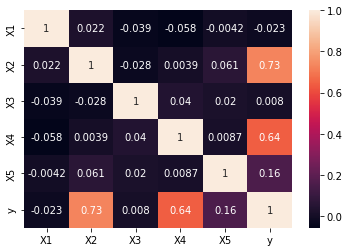

In [5]:
sns.heatmap(df.corr(), annot=True);

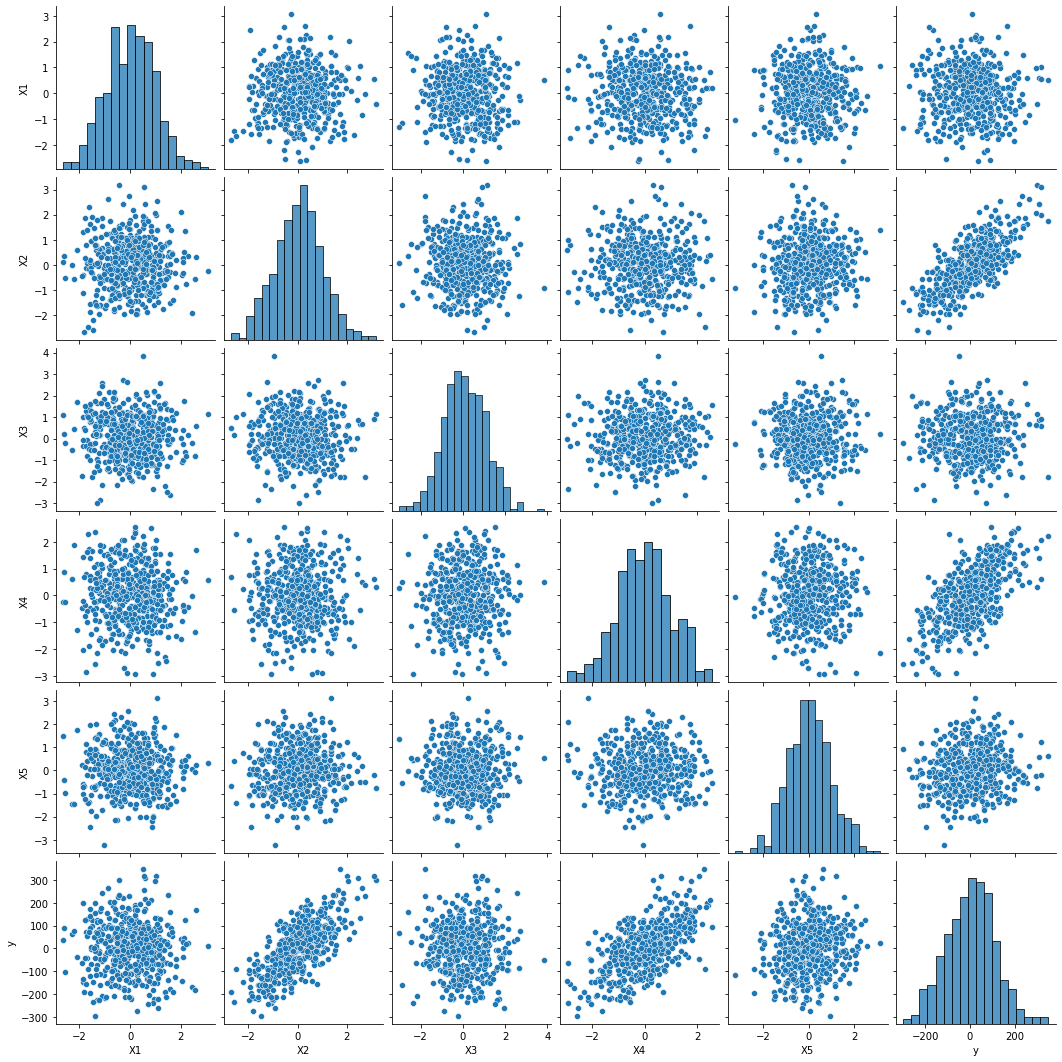

In [6]:
sns.pairplot(df)

In [7]:
df.describe()

,X1,X2,X3,X4,X5,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012412,0.047211,0.089335,-0.004983,0.024845,3.420332
std,0.955087,0.969309,0.999397,1.038814,0.949985,110.693405
min,-2.650970,-2.703232,-3.019512,-2.940389,-3.241267,-297.665107
25%,-0.642849,-0.577418,-0.576895,-0.682826,-0.644153,-68.294863
50%,0.033078,0.081273,0.040829,-0.024875,0.008918,4.208483
75%,0.658720,0.668974,0.751524,0.671004,0.635892,76.120529
max,3.078881,3.193108,3.852731,2.558199,3.137749,349.448456


Os dados não têm variação de escala tão grande, então não nos preocuparemos em normaliza-los, caso queiramos utilizar regularização!

**Mas nunca se esqueça que isso é bastante importante quando há grandes diferenças de escala!!**


Agora, implementamos o CV:

In [8]:
from sklearn.model_selection import KFold

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
vars(kf)

{'n_splits': 5, 'shuffle': True, 'random_state': 42}

In [11]:
# qtos splists ha?

len(list(kf.split(X)))

5

In [12]:
# em cada split, temos uma tupla ([indices de treino], [indices de validação])
# como visto acima, isso é feito pra cada split
# o que temos abaixo é apenas o primeiro split (indice 0)

list(kf.split(X))[0]

(array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
         19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
         35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
         50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
         65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
         92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
        150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
        181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222

In [13]:
idcs_treino, idcs_val = list(kf.split(X))[0]

In [14]:
idcs_val

array([  0,   2,   9,  11,  15,  18,  22,  30,  33,  39,  46,  55,  63,
        68,  69,  70,  72,  73,  75,  76,  77,  78,  79,  82,  84,  86,
        90,  93, 101, 104, 124, 131, 148, 154, 155, 172, 173, 180, 182,
       185, 193, 194, 204, 209, 211, 238, 262, 268, 277, 278, 280, 290,
       304, 312, 316, 317, 321, 323, 324, 333, 334, 336, 341, 347, 352,
       356, 361, 362, 371, 374, 377, 381, 384, 388, 391, 394, 406, 408,
       409, 410, 414, 415, 431, 438, 440, 450, 451, 455, 461, 465, 472,
       475, 477, 483, 485, 490, 491, 494, 495, 497])

In [15]:
idcs_treino

array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
        19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
        35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
        65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
        92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
       150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
       181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

Como vimos acima, a classe KFold só gera os splits.

Mas, na prática, vamos usar o `cross_validate()`, que tem o KFold como argumento!!!

In [16]:
from sklearn.model_selection import cross_validate



In [17]:
## Estimador para regressão que aplica Regularização
en = ElasticNet()
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=en, X=X, y=y, 
                           cv=kf5, scoring="neg_mean_absolute_error",
                           return_train_score=True)

NameError: name 'ElasticNet' is not defined

In [ ]:
df_result_cv = pd.DataFrame(result_cv)

df_result_cv = df_result_cv.abs()

# df_result_cv["test_score"] = df_result_cv["test_score"]*(-1)
# df_result_cv["train_score"] = df_result_cv["train_score"]*(-1)

Vamos olhar pros resultados mais de perto...

In [ ]:
df_result_cv

In [ ]:
df_result_cv[["train_score", "test_score"]].describe()

In [ ]:
sns.histplot(data=df_result_cv, x="train_score", kde=True)

In [ ]:
sns.histplot(data=df_result_cv, x="test_score", kde=True)

Numa unica celula:


In [ ]:
def plot_cv(estimator, X, y, n_splits, scoring):
    '''
    scoring: string relativa às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    display(df_result_cv[["train_score", "test_score"]].describe())
    
    # ============================
    
    print("\nDistribuição de métricas de treino:")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    plt.show()
    
    print("\nDistribuição de métricas de teste:")
    sns.histplot(data=df_result_cv, x="test_score", kde=True)
    plt.show()
    
    print("\nAs duas juntas (compare a variância!):")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    sns.histplot(data=df_result_cv, x="test_score", color="orange", kde=True)
    plt.show()

## Repetindo para split em 30

In [ ]:
en = ElasticNet()

plot_cv(en, X, y, n_splits=30, scoring="neg_mean_absolute_error")

Comparando com o train-test split direto

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ================================

en = ElasticNet().fit(X_train, y_train)

# ================================

from sklearn.metrics import mean_absolute_error

y_pred_train = en.predict(X_train)
print("\nMétrica de treino:")
print(mean_absolute_error(y_train, y_pred_train))

y_pred_test = en.predict(X_test)
print("\nMétrica de teste:")
print(mean_absolute_error(y_test, y_pred_test))

**Na prática, para bases maiores, nós fazemos realmente como está na figura lá em cima**

Isto é:

- primeiro fazemos o train-test split;
- aí, aplicamos CV na base de treino;
- depois testamos na base de teste

Isso é sobretudo importante no segundo "uso" do cv, que é otimização de hiperparametros

______
_____
____

Caso queira usar mais métricas de uma vez... SEM PROBLEMAS :)

In [ ]:
n_splits = 5
estimator = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                           cv=kf5, scoring=scoring,
                           return_train_score=True)

# ============================

df_result_cv = pd.DataFrame(result_cv)
df_result_cv = df_result_cv.abs()

df_result_cv

In [ ]:
colunas_metricas = df_result_cv.columns.tolist()[2:]

for i in range(0, len(colunas_metricas), 2):
    
    display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())
    
    print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
    plt.show()
    
    print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
    plt.show()

    print("#"*80)

_______________

In [ ]:
def plot_cv_varias_metricas(estimator, X, y, n_splits, scoring):
    '''
    scoring: tupla de strings relativas às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    colunas_metricas = df_result_cv.columns.tolist()[2:]

    for i in range(0, len(colunas_metricas), 2):

        display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())

        print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
        plt.show()

        print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
        plt.show()

        print("\nAs duas juntas (compare a variância!):")
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], label="treino", kde=True)
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], color="orange", label="teste", kde=True)
        plt.legend()
        plt.show()
        
        print("#"*80)
    

In [ ]:
en = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

plot_cv_varias_metricas(en, X, y, n_splits=30, scoring=scoring)

_____

Vamos agora ver um caso de **classificação**:

In [ ]:
from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(n_samples=500,
                                 n_features=5, n_informative=3,
                                 n_classes=2,
                                 random_state=42)

X_clf_df = pd.DataFrame(X_clf, columns=[f'X{i+1}' for i in range(X_clf.shape[1])]) 
y_clf_df = pd.Series(y_clf, name="y")
                        
df_clf = pd.concat([X_clf_df, y_clf_df], axis=1)

df_clf

In [ ]:
sns.pairplot(df_clf, hue="y")

Agora, o CV, bem parecido com o que fizemos acima:

- uma regressão logística com regularização l1 e fator de regularização (C) igual a 1.2;
- 10 folds;
- roc_auc como métrica de avaliação.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv(lr, X_clf, y_clf, n_splits=10, scoring="roc_auc")

In [ ]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv_varias_metricas(lr, X_clf, y_clf, n_splits=10, scoring=("roc_auc", "f1"))

### Agora é sua vez!!

- 1 - Teste diferentes regressores CV com a base house_prices
    - Aumente a complexidade da hipótese permitindo uma regressão polinomial, e deixe o CV decidir uma boa regularização!
    

In [ ]:
house_prices = pd.read_csv('house_prices.csv')

In [ ]:
house_prices

In [ ]:
house_prices_filtered = house_prices.select_dtypes(include='number')
house_prices_filtered = house_prices_filtered.dropna()

X = house_prices_filtered.drop(columns=['Id','SalePrice'], axis = 1)
y = house_prices_filtered['SalePrice']

In [ ]:
X.describe()

In [ ]:
# house_prices
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_mms = scaler.fit_transform(X)

In [ ]:
en = ElasticNet()

In [ ]:
plot_cv_varias_metricas(en, X, y, n_splits=30, scoring=["neg_root_mean_squared_error", "r2"])

In [ ]:
Z = X**2
y2 = y**2

In [ ]:
house_prices_filtered.corr()['SalePrice'].abs().sort_values(ascending=False)

In [ ]:
plot_cv_varias_metricas(en, X, y, n_splits=30, scoring=["neg_root_mean_squared_error", "r2"])

- 2 - Aplique o logit com CV à base breast_cancer

In [ ]:
# breast_cancer


____________

## 2) Ajuste de hiperparâmetros

Além de permitir uma avaliação mais robusta de um modelo, o CV pode também ser utilizado para um propósito muito importante: **a escolha de valores adequados de hiperparâmetros** de um modelo -- processo conhecido como **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

Na aula que vem vamos estudar uma forma mais estruturada de fazer este procedimento.

Mas, nesta aula, vamos ver formas automáticas e diretas de aplicar CV aos modelos que conhecemos!

Antes de irmos pra prática, uma pergunta importante é: **como/por que utilizar CV para o ajuste de hiperparâmetros?**

Ao testarmos diferentes valores/combinações de hiperparâmetros em diferentes folds, temos uma estimativa mais realista sobre o efeito destas escolhas: se o resultado for bom em todos os folds (ou bom em média), temos um indicativo mais robusto de que de fato aquela é uma boa escolha. Em particular, fica muito mais difícil de cometermos **overfitting** através da escolha de hiperparâmetros que ajustem muito bem uma única base de treino. Faz sentido, né?

Para saber mais sobre estas questões, sugiro [este post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) e [este post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

No sklearn, temos o procedimento de CV incorporado a algumas classes de hipóteses:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Em todos os casos, é possível especificar uma lista de hiperparâmetros a serem percorridos, e o modelo com melhor hiperparâmetro (ou combinação de hiperparâmetros) é escolhido! 

In [ ]:
y

Vamos pegar as bases acima e aplicar os métodos de CV built-in pra ver se encontramos resultados melhores:

In [ ]:
np.linspace(0.1, 1, 100)

In [ ]:
from sklearn.linear_model import LassoCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

l1 = LassoCV(alphas=np.linspace(0.1, 1, 100), cv=kf5, verbose=50).fit(X, y)

In [ ]:
l1

In [ ]:
l1.alpha_

In [ ]:
from sklearn.linear_model import ElasticNetCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

en = ElasticNetCV(alphas=np.linspace(0.5, 1, 20), l1_ratio=np.linspace(0.1, 1, 20),
                  cv=kf5, verbose=50).fit(X, y)

In [ ]:
en.alpha_

In [ ]:
en.l1_ratio_

# Revisão e resumo da aula

A validação cruzada possuí dois usos fundamentais, a avaliação do modelo e a otimização de hiperparametros, vamos revisar os 2 abaixo:

## Avaliação

Sobre a avaliação do modelo, a idéia é que podemos utilizar a validação cruzada para verificar as performances de cada um dos Folds que criamos. Aqui, aproveito para fazer uma retificação, a idéia não é verificar se um Fold performou mal, mas sim utilizar a média ou a mediana dos folds como uma estimativa de como a métrica performou (r² por exemplo).

O processo em etapas para fazer uso dessa técnica é o seguinte:

1 -  Decidir o estimador
- Esta etapa é bastante importante pois se formos usar um estimador que seja muito influenciado pela distância entre as variáveis (como os estimadores que usam regularização), precisamos aplicar uma normalização.

2 - Se for o caso de trabalharmos com uma base que exija essa normalização precisamos utilizar um escalador. Este caso em particular será melhor abordado na aula 5, onde aprenderemos pipelines

3 - Criar um objeto de Kfolds para fazer a divisão, este parametro sera passado para o método cross_validate do sklearn, junto com o estimador

4 - Invocar o método cross_validate

5 - Avaliar as métricas de acordo com as regras de negócio (ou a convenção do curso), usando referencias como a média ou a mediana das amostras medidas pelo cross_validate. Estas métricas darão uma boa noção de se a base como um todo generaliza bem o problema

## Otimização

O processo de otimização de hiperparâmetros usando cross validation é bastante interessante, nas próximas aulas aprenderemos metodologias mais diretas de fazer isso. Por enquanto, temos que nos ater aos exemplos com hiperparametros que temos, como os estimadores que utilizam regularização. Vejamos o passo a passo.

1 - Dividir a base em Kfolds

2 - Instanciar um estimador que aplique CV ao estimador escolhido, os que conhecemos no momento são:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

3 - Fazer o fit com o modelo, em background, o CV já será feito.

4 - Uma vez que o modelo tiver feito o fit utilizando o CV para otimizar os hiperparâmetros, podemos ver no estimador que instanciamos quais valores os hiperparametros assumiram